In this practice, I will:
1. Explore the COVID-19 CT dataset.
2. Preprocess the data for segmentation tasks.
3. Build a segmentation model using a U-Net architecture.
4. Train the model and evaluate its performance.

In [2]:
import os

def concatenate_files(output_file, chunk_prefix):
    with open(output_file, 'wb') as outfile:
        chunk_files = sorted([f for f in os.listdir('.') if f.startswith(chunk_prefix)])
        
        for chunk_file in chunk_files:
            with open(chunk_file, 'rb') as infile:
                outfile.write(infile.read())
            print(f"Added {chunk_file} to {output_file}")
    print(f"File {output_file} created successfully!")

concatenate_files('images_medseg.npy', 'images_part_')
concatenate_files('masks_medseg.npy', 'masks_part_')

Added images_part_aa to images_medseg.npy
Added images_part_ab to images_medseg.npy
Added images_part_ac to images_medseg.npy
Added images_part_ad to images_medseg.npy
Added images_part_ae to images_medseg.npy
File images_medseg.npy created successfully!
Added masks_part_aa to masks_medseg.npy
Added masks_part_ab to masks_medseg.npy
Added masks_part_ac to masks_medseg.npy
File masks_medseg.npy created successfully!


In [3]:
import numpy as np
import os
data_path = './'     # this could be changed if you put the training data to other places
images_medseg = np.load(os.path.join(data_path, 'images_medseg.npy'))
masks_medseg = np.load(os.path.join(data_path, 'masks_medseg.npy'))

### 🖼️ Image Data Types
- **Loaded images**: `float64`
- **Recommended type**: `float32` for training deep learning models

**Why use `float32`?**
- Reduces memory usage
- Enables faster computation (especially on GPUs optimized for 32-bit)
- Offers sufficient numerical precision (~7 significant digits)
- Avoids numerical instability from lower-precision types like `float16`

---

### 🎯 Segmentation Mask Data Types
- **Current mask type**: `bool`
- **Typical choice**: Integer types such as `int32` or `uint8`

**Why use integers?**
- Each pixel represents a discrete class label:
  - `0 = background`
  - `1 = class A`
  - `2 = class B`, etc.
- `bool` is also valid for **binary segmentation tasks**

In [4]:
import matplotlib.pyplot as plt

def visualize(image_batch, mask_batch=None, pred_batch=None, num_samples=8, hot_encode=True):
    num_classes = mask_batch.shape[-1] if mask_batch is not None else 0
    fix, ax = plt.subplots(num_classes + 1, num_samples, figsize=(num_samples * 2, (num_classes + 1) * 2))

    for i in range(num_samples):
        ax_image = ax[0, i] if num_classes > 0 else ax[i]
        if hot_encode:
            ax_image.imshow(image_batch[i,:,:,0], cmap='Greys')
        else:
            ax_image.imshow(image_batch[i,:,:])
        ax_image.set_xticks([])
        ax_image.set_yticks([])

        if mask_batch is not None:
            for j in range(num_classes):
                if pred_batch is None:
                    mask_to_show = mask_batch[i,:,:,j]
                else:
                    mask_to_show = np.zeros(shape=(*mask_batch.shape[1:-1], 3))
                    mask_to_show[..., 0] = pred_batch[i,:,:,j].cpu().numpy() > 0.5
                    mask_to_show[..., 1] = mask_batch[i,:,:,j]
                ax[j + 1, i].imshow(mask_to_show, vmin=0, vmax=1)
                ax[j + 1, i].set_xticks([])
                ax[j + 1, i].set_yticks([])

    plt.tight_layout()
    plt.show()


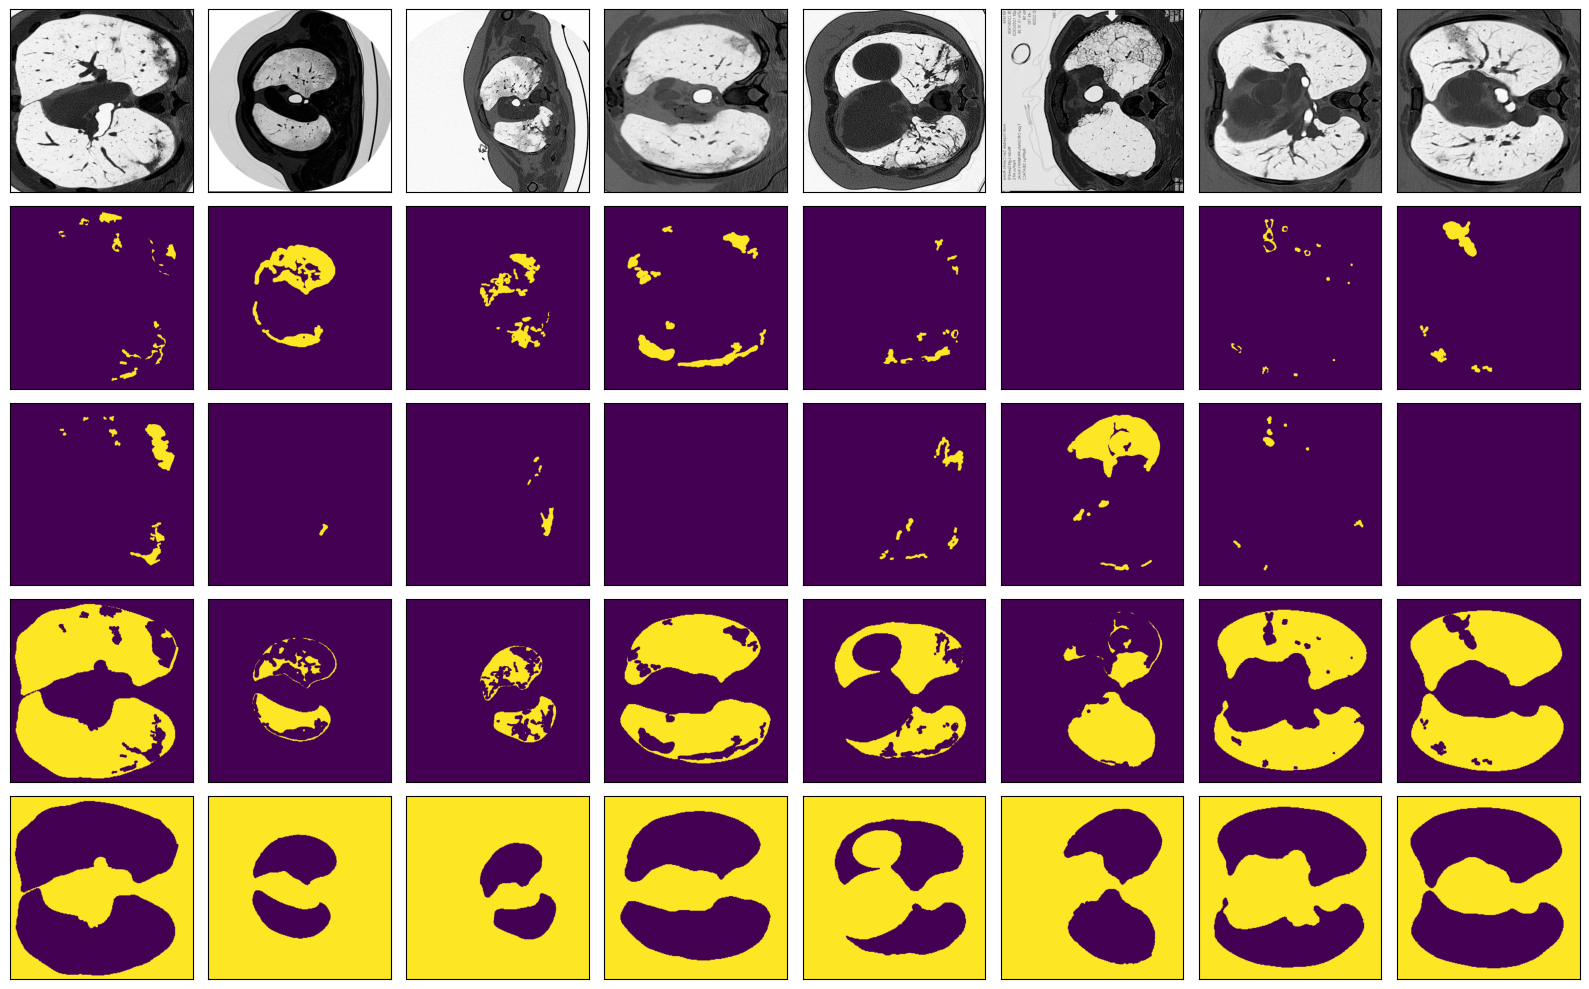

In [5]:
visualize(images_medseg[10:], masks_medseg[10:])

Lets visualise say the 10th image

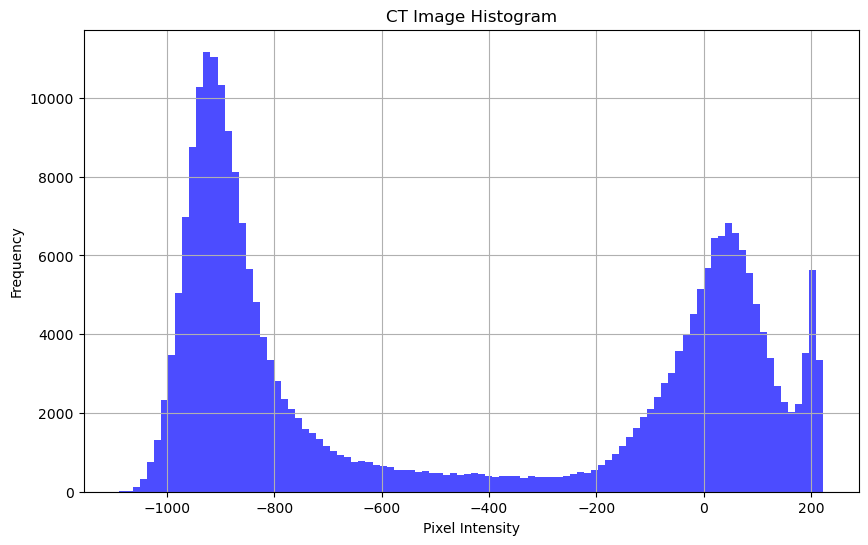

In [6]:
def visualize_histogram(image):
    plt.figure(figsize=(10, 6))
    plt.hist(image.flatten(), bins=100, color='blue', alpha=0.7)
    plt.title('CT Image Histogram')
    plt.xlabel('Pixel Intensity')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()
visualize_histogram(images_medseg[10])

#### Window shift and normalization
From the histogram above, you will find most pixels range between [-1000, -700] and [-200,200]. In computed tomography (CT), a window transform refers to the process of adjusting the display settings to focus on specific ranges of Hounsfield Units (HU), which correspond to different tissue densities. This adjustment enhances the visibility of certain tissues or structures in the CT images by mapping the HU range to the grayscale display.

**Common Window Settings in CT**
Lung: WW ~ 1500 HU, WL ~ -600 HU.
Bone: WW ~ 2000 HU, WL ~ 500 HU.
Soft Tissue Window: WW ~ 400 HU, WL ~ 40 HU.

In [7]:
# function for window shift with WW ~ 1500 HU, WL ~ -600 HU, and rescale the image to [0,1]
def window_shift_and_normalize(ct_image, window_center, window_width):
    # Step 1: Calculate the window bounds
    window_min = window_center - (window_width / 2)
    window_max = window_center + (window_width / 2)

    # Step 2: Clip the image to the window range
    shifted_image = np.clip(ct_image, window_min, window_max)

    # Step 3: Normalize the image to [0, 1]
    normalized_image = (shifted_image - window_min) / (window_max - window_min)

    return normalized_image

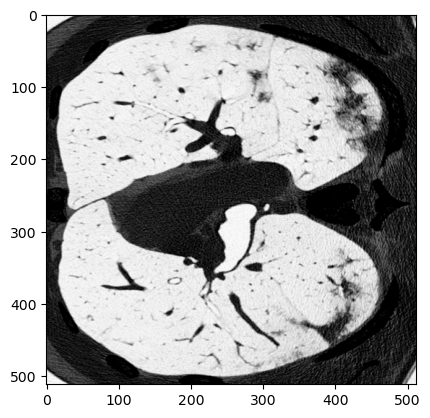

In [8]:
image_10th, masks_10th = images_medseg[10], masks_medseg[10]
image_trans = window_shift_and_normalize(image_10th,-600, 1500)
plt.figure()
plt.imshow(image_trans*255,cmap='Greys')
plt.show()

Ill merge the one-hot mask to the segmentation mask for visualization 


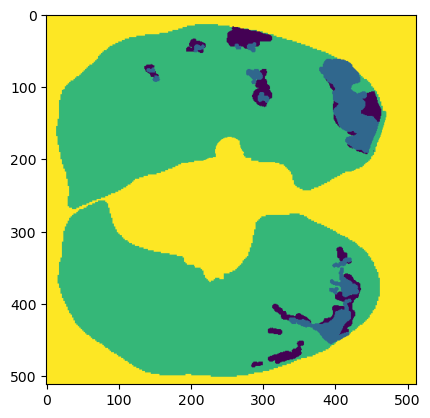

In [9]:
seg_mask10 = np.argmax(masks_10th,axis=-1)
plt.figure()
plt.imshow(seg_mask10)
plt.show()

I will now build a pytorch dataloader and Neural Network using a simple U-Net. The DataLoader in PyTorch is a utility that provides an efficient way to load and preprocess data for training or inference in deep learning models. It works by combining a dataset and a sampler, allowing you to easily iterate over data in batches, shuffle data, and use multiprocessing to speed up data loading.

In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
import random

class Covid19_Dataloader(Dataset):
    def __init__(self, images, masks, flip_prob=0.5):
        self.images = images
        self.masks = masks
        self.flip_prob = flip_prob
        self.to_Tensor = transforms.ToTensor()

    def __len__(self):
        return len(self.images)

    def window_shift_and_normalize(self, ct_image, window_center, window_width):
        window_min = window_center - (window_width / 2)
        window_max = window_center + (window_width / 2)

        shifted_image = np.clip(ct_image, window_min, window_max)

        normalized_image = (shifted_image - window_min) / (window_max - window_min)

        return normalized_image

    def random_flip(self, image, mask):
        """Randomly flip both image and mask horizontally and/or vertically."""
        if random.random() < self.flip_prob:
            # Horizontal flip
            image = torch.flip(image, dims=[2])
            mask = torch.flip(mask, dims=[2])
        if random.random() < self.flip_prob:
            # Vertical flip
            image = torch.flip(image, dims=[1])
            mask = torch.flip(mask, dims=[1])
        return image, mask

    def __getitem__(self, idx):
        image = self.images[idx]
        image = self.window_shift_and_normalize(image, window_center=-600, window_width=1500)
        mask = self.masks[idx]
        image_T, mask_T = self.to_Tensor(image.astype(np.float32)), self.to_Tensor(mask.astype(np.float32))
        image, mask = self.random_flip(image_T, mask_T)
        return image, mask


In [11]:
# Fully Connected Network
class FCN(nn.Module):
    def __init__(self, num_classes=2):
        super(FCN, self).__init__()

        self.encoder = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2)
        )

        self.decoder = nn.Sequential(
            nn.Conv2d(256, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),

            nn.Conv2d(128, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),

            nn.Conv2d(64, num_classes, kernel_size=3, padding=1)
        )

        self.upsample = nn.Upsample(scale_factor=8, mode='bilinear', align_corners=True)

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        x = self.upsample(x)
        return x

In [12]:
# U-Net
class DoubleConv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True)
        )

    def forward(self, input):
        return self.conv(input)


class UNet(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(UNet, self).__init__()

        self.conv1 = DoubleConv(in_ch, 32)
        self.pool1 = nn.MaxPool2d(2)
        self.conv2 = DoubleConv(32, 64)
        self.pool2 = nn.MaxPool2d(2)
        self.conv3 = DoubleConv(64, 128)
        self.pool3 = nn.MaxPool2d(2)
        self.conv4 = DoubleConv(128, 256)
        self.pool4 = nn.MaxPool2d(2)
        self.conv5 = DoubleConv(256, 512)
        self.up6 = nn.ConvTranspose2d(512, 256, 2, stride=2)
        self.conv6 = DoubleConv(512, 256)
        self.up7 = nn.ConvTranspose2d(256, 128, 2, stride=2)
        self.conv7 = DoubleConv(256, 128)
        self.up8 = nn.ConvTranspose2d(128, 64, 2, stride=2)
        self.conv8 = DoubleConv(128, 64)
        self.up9 = nn.ConvTranspose2d(64, 32, 2, stride=2)
        self.conv9 = DoubleConv(64, 32)
        self.conv10 = nn.Conv2d(32, out_ch, 1)

    def forward(self, x):
        #print(x.shape)
        c1 = self.conv1(x)
        p1 = self.pool1(c1)
        #print(p1.shape)
        c2 = self.conv2(p1)
        p2 = self.pool2(c2)
        #print(p2.shape)
        c3 = self.conv3(p2)
        p3 = self.pool3(c3)
        #print(p3.shape)
        c4 = self.conv4(p3)
        p4 = self.pool4(c4)
        #print(p4.shape)
        c5 = self.conv5(p4)
        up_6 = self.up6(c5)
        merge6 = torch.cat([up_6, c4], dim=1)
        c6 = self.conv6(merge6)
        up_7 = self.up7(c6)
        merge7 = torch.cat([up_7, c3], dim=1)
        c7 = self.conv7(merge7)
        up_8 = self.up8(c7)
        merge8 = torch.cat([up_8, c2], dim=1)
        c8 = self.conv8(merge8)
        up_9 = self.up9(c8)
        merge9 = torch.cat([up_9, c1], dim=1)
        c9 = self.conv9(merge9)
        c10 = self.conv10(c9)
        out = nn.Sigmoid()(c10)
        return out

To compute the Attention U-Net, i need the attention block.

In [13]:
class Attention_block(nn.Module):
    def __init__(self, F_g, F_l, F_int):
        super(Attention_block, self).__init__()
        self.W_g = nn.Sequential(
            nn.Conv2d(F_g, F_int, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(F_int)
        )

        self.W_x = nn.Sequential(
            nn.Conv2d(F_l, F_int, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(F_int)
        )

        self.psi = nn.Sequential(
            nn.Conv2d(F_int, 1, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(1),
            nn.Sigmoid()
        )

        self.relu = nn.ReLU(inplace=True)

    def forward(self, g, x):
        # 1x1 conv for signal g
        g1 = self.W_g(g)
        # 1x1 conv for signal x^l
        x1 = self.W_x(x)
        # concat + relu
        psi = self.relu(g1 + x1)
        # get attention map
        psi = self.psi(psi)
        return x * psi

Now I can build the Attention U-Net

In [14]:
class conv_block(nn.Module):
    def __init__(self,ch_in,ch_out):
        super(conv_block,self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(ch_in, ch_out, kernel_size=3,stride=1,padding=1,bias=True),
            nn.BatchNorm2d(ch_out),
            nn.ReLU(inplace=True),
            nn.Conv2d(ch_out, ch_out, kernel_size=3,stride=1,padding=1,bias=True),
            nn.BatchNorm2d(ch_out),
            nn.ReLU(inplace=True)
        )
    def forward(self,x):
        x = self.conv(x)
        return x

class up_conv(nn.Module):
    def __init__(self,ch_in,ch_out):
        super(up_conv,self).__init__()
        self.up = nn.Sequential(
            nn.Upsample(scale_factor=2),
            nn.Conv2d(ch_in,ch_out,kernel_size=3,stride=1,padding=1,bias=True),
		    nn.BatchNorm2d(ch_out),
			nn.ReLU(inplace=True)
        )

    def forward(self,x):
        x = self.up(x)
        return x


class AttentionUNet(nn.Module):
    def __init__(self, img_ch=3, output_ch=1):
        super(AttentionUNet, self).__init__()

        self.Maxpool = nn.MaxPool2d(kernel_size=2, stride=2)

        self.Conv1 = conv_block(ch_in=img_ch, ch_out=64)
        self.Conv2 = conv_block(ch_in=64, ch_out=128)
        self.Conv3 = conv_block(ch_in=128, ch_out=256)
        self.Conv4 = conv_block(ch_in=256, ch_out=512)
        self.Conv5 = conv_block(ch_in=512, ch_out=1024)

        self.Up5 = up_conv(ch_in=1024, ch_out=512)
        self.Att5 = Attention_block(F_g=512, F_l=512, F_int=256)
        self.Up_conv5 = conv_block(ch_in=1024, ch_out=512)

        self.Up4 = up_conv(ch_in=512, ch_out=256)
        self.Att4 = Attention_block(F_g=256, F_l=256, F_int=128)
        self.Up_conv4 = conv_block(ch_in=512, ch_out=256)

        self.Up3 = up_conv(ch_in=256, ch_out=128)
        self.Att3 = Attention_block(F_g=128, F_l=128, F_int=64)
        self.Up_conv3 = conv_block(ch_in=256, ch_out=128)

        self.Up2 = up_conv(ch_in=128, ch_out=64)
        self.Att2 = Attention_block(F_g=64, F_l=64, F_int=32)
        self.Up_conv2 = conv_block(ch_in=128, ch_out=64)

        self.Conv_1x1 = nn.Conv2d(64, output_ch, kernel_size=1, stride=1, padding=0)
        self.sigmoid = nn.Sigmoid()
    def forward(self, x):
        # encoding path
        x1 = self.Conv1(x)

        x2 = self.Maxpool(x1)
        x2 = self.Conv2(x2)

        x3 = self.Maxpool(x2)
        x3 = self.Conv3(x3)

        x4 = self.Maxpool(x3)
        x4 = self.Conv4(x4)

        x5 = self.Maxpool(x4)
        x5 = self.Conv5(x5)

        # decoding + concat path
        d5 = self.Up5(x5)
        x4 = self.Att5(g=d5, x=x4)
        d5 = torch.cat((x4, d5), dim=1)
        d5 = self.Up_conv5(d5)

        d4 = self.Up4(d5)
        x3 = self.Att4(g=d4, x=x3)
        d4 = torch.cat((x3, d4), dim=1)
        d4 = self.Up_conv4(d4)

        d3 = self.Up3(d4)
        x2 = self.Att3(g=d3, x=x2)
        d3 = torch.cat((x2, d3), dim=1)
        d3 = self.Up_conv3(d3)

        d2 = self.Up2(d3)
        x1 = self.Att2(g=d2, x=x1)
        d2 = torch.cat((x1, d2), dim=1)
        d2 = self.Up_conv2(d2)

        d1 = self.Conv_1x1(d2)
        d1 = self.sigmoid(d1)

        return d1

Now that I have everything, I will train my model.

In [22]:
from sklearn.model_selection import train_test_split

model = UNet(in_ch=1, out_ch=4)
X_train, X_val, y_train, y_val = train_test_split(images_medseg, masks_medseg, test_size=0.2, random_state=42)

train_dataset = Covid19_Dataloader(X_train, y_train, flip_prob=0.45)
val_dataset = Covid19_Dataloader(X_val, y_val,  flip_prob=0.45)
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0005)

# Training loop
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
epochs = 30

In [21]:
unique_classes = torch.unique(masks)
print("Unique mask values:", unique_classes)


Unique mask values: tensor([0., 1.])


Epoch 1/30, Loss: 1.3550
Epoch 2/30, Loss: 1.2865
Epoch 3/30, Loss: 1.2349
Epoch 4/30, Loss: 1.1928
Epoch 5/30, Loss: 1.1520
Epoch 6/30, Loss: 1.1098
Epoch 7/30, Loss: 1.0727
Epoch 8/30, Loss: 1.0586
Epoch 9/30, Loss: 1.0223
Epoch 10/30, Loss: 0.9968
Epoch 11/30, Loss: 0.9783
Epoch 12/30, Loss: 0.9890
Epoch 13/30, Loss: 0.9449
Epoch 14/30, Loss: 0.9335
Epoch 15/30, Loss: 0.9275
Epoch 16/30, Loss: 0.9163
Epoch 17/30, Loss: 0.8934
Epoch 18/30, Loss: 0.8854
Epoch 19/30, Loss: 0.8729
Epoch 20/30, Loss: 0.8664
Epoch 21/30, Loss: 0.8617
Epoch 22/30, Loss: 0.8549
Epoch 23/30, Loss: 0.8517
Epoch 24/30, Loss: 0.8475
Epoch 25/30, Loss: 0.8464
Epoch 26/30, Loss: 0.8440
Epoch 27/30, Loss: 0.8380
Epoch 28/30, Loss: 0.8436
Epoch 29/30, Loss: 0.8365
Epoch 30/30, Loss: 0.8332


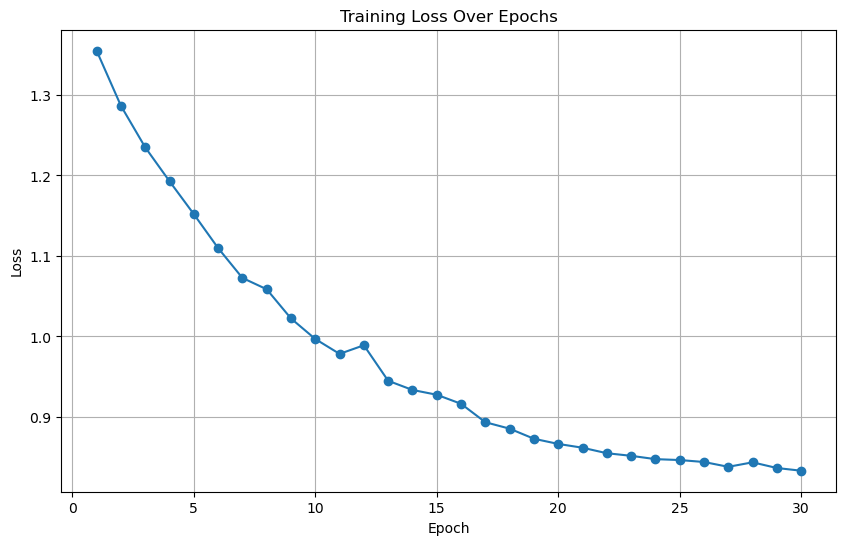

In [23]:
train_losses = []
for epoch in range(epochs):
    model.train()
    train_loss = 0
    for images, masks in train_loader:
        images, masks = images.to(device), masks.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, masks.argmax(dim=1).long())
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    average_loss = train_loss / len(train_loader)
    train_losses.append(average_loss)
    print(f"Epoch {epoch+1}/{epochs}, Loss: {average_loss:.4f}")

plt.figure(figsize=(10, 6))
plt.plot(range(1, epochs + 1), train_losses, marker='o', linestyle='-')
plt.title('Training Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.show()

Now I will evaluate the model using Intersection of Union

In [24]:
import torch.nn.functional as F
def mIoU(pred_mask, mask, smooth=1e-10, n_classes=4):
    with torch.no_grad():
        pred_mask = F.softmax(pred_mask, dim=1)
        pred_mask = torch.argmax(pred_mask, dim=1)
        pred_mask = pred_mask.contiguous().view(-1)
        mask = mask.contiguous().view(-1)

        iou_per_class = []
        for clas in range(0, n_classes): #loop per pixel class
            true_class = pred_mask == clas
            true_label = mask == clas

            if true_label.long().sum().item() == 0: #no exist label in this loop
                iou_per_class.append(np.nan)
            else:
                intersect = torch.logical_and(true_class, true_label).sum().float().item()
                union = torch.logical_or(true_class, true_label).sum().float().item()

                iou = (intersect + smooth) / (union +smooth)
                iou_per_class.append(iou)
        return np.nanmean(iou_per_class)

In [25]:
val_ious = []
train_losses = []
for epoch in range(epochs):
    # Training Loop
    model.train()
    train_loss = 0
    for images, masks in train_loader:
        images, masks = images.to(device), masks.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    train_losses.append(train_loss / len(train_loader))

    # Validation Loop
    model.eval()
    iou_scores = []
    with torch.no_grad():
        for images, masks in val_loader:
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)
            iou = mIoU(outputs, torch.argmax(masks,dim=1))
            iou_scores.append(iou)

    average_iou = np.mean(iou_scores)
    val_ious.append(average_iou)

    print(f"Epoch {epoch+1}/{epochs}, Loss: {train_losses[-1]:.4f}, IoU: {average_iou:.4f}")

Epoch 1/30, Loss: 0.8283, IoU: 0.5142
Epoch 2/30, Loss: 0.8297, IoU: 0.5203
Epoch 3/30, Loss: 0.8245, IoU: 0.5286
Epoch 4/30, Loss: 0.8185, IoU: 0.5293
Epoch 5/30, Loss: 0.8201, IoU: 0.5133
Epoch 6/30, Loss: 0.8211, IoU: 0.5270
Epoch 7/30, Loss: 0.8194, IoU: 0.4953
Epoch 8/30, Loss: 0.8165, IoU: 0.4974
Epoch 9/30, Loss: 0.8148, IoU: 0.5009
Epoch 10/30, Loss: 0.8132, IoU: 0.5301
Epoch 11/30, Loss: 0.8167, IoU: 0.5266
Epoch 12/30, Loss: 0.8159, IoU: 0.5124
Epoch 13/30, Loss: 0.8168, IoU: 0.5118
Epoch 14/30, Loss: 0.8183, IoU: 0.4886
Epoch 15/30, Loss: 0.8130, IoU: 0.5285
Epoch 16/30, Loss: 0.8134, IoU: 0.5107
Epoch 17/30, Loss: 0.8118, IoU: 0.5306
Epoch 18/30, Loss: 0.8129, IoU: 0.5337
Epoch 19/30, Loss: 0.8072, IoU: 0.5305
Epoch 20/30, Loss: 0.8075, IoU: 0.5374
Epoch 21/30, Loss: 0.8089, IoU: 0.4974
Epoch 22/30, Loss: 0.8060, IoU: 0.5128
Epoch 23/30, Loss: 0.8028, IoU: 0.5313
Epoch 24/30, Loss: 0.8041, IoU: 0.5247
Epoch 25/30, Loss: 0.8024, IoU: 0.5334
Epoch 26/30, Loss: 0.8028, IoU: 0.

To improve the performance, I can
1. Use more powerful architectures (UNet++)
2. Use different loss functions (you may try dice coefficient loss)
3. Use more data 